In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [3]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/MyDrive/IS403/Project/Data


# Function

In [4]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
def train_test_valid(data):
  train_size = int(0.7 * len(data))
  test_size = int(0.2 * len(data))
  val_size = len(data) - train_size - test_size

  train_data = data[:train_size]
  test_data = data[train_size:train_size+test_size]
  valid_data = data[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

# AMAZON

## Data

In [ ]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [ ]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [ ]:
data_amz =df_amz[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

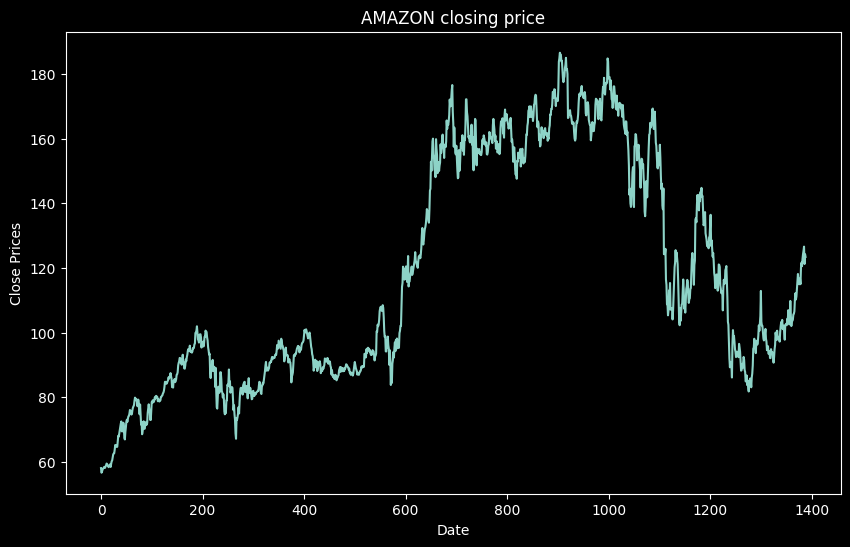

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_amz = scaler.fit_transform(np.array(data_amz).reshape(-1,1))

In [ ]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_amz)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(valid_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Build & train model

In [ ]:
model = SVR()

### Choose k

In [ ]:
param_grid = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', cv=10)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid.best_params_

{'kernel': 'linear'}

### Train

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

## Eval

In [ ]:
y_pred_val = svr.predict(X_val)
y_pred = svr.predict(X_test)

y_pred_val = y_pred_val.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
eval(org_y_test,y_pred,org_y_val,y_pred_val)

** Testing **
MAE:  9.279754732154494
MAPE:  7.815924511524987
RMSE:  11.16351750852301

** Validate **
MAE:  4.516221242595331
MAPE:  3.923741003563254
RMSE:  5.4553116564452235


## Predict

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        print("{} day output {}".format(i,yhat))

        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr.predict(x_input)
        print(yhat)

        temp_input.extend(yhat.tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i=i+1

[0.32686512]
101
1 day output [0.32235312]
2 day output [0.31729218]
3 day output [0.31498714]
4 day output [0.31181022]
5 day output [0.30694209]
6 day output [0.30564891]
7 day output [0.30582042]
8 day output [0.31122343]
9 day output [0.31673588]
10 day output [0.32331112]
11 day output [0.32768606]
12 day output [0.33331719]
13 day output [0.3364831]
14 day output [0.33874326]
15 day output [0.34130487]
16 day output [0.34359883]
17 day output [0.34402748]
18 day output [0.34822206]
19 day output [0.35162066]
20 day output [0.35821023]
21 day output [0.36528948]
22 day output [0.37238444]
23 day output [0.37684019]
24 day output [0.38086795]
25 day output [0.38654233]
26 day output [0.39303795]
27 day output [0.39820426]
28 day output [0.40141873]
29 day output [0.40456908]


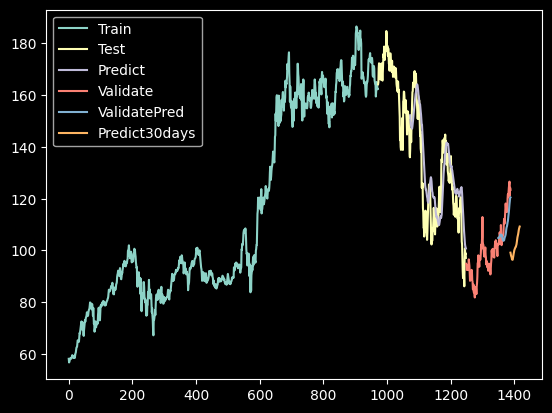

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(valid_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data_amz)-1, stop=len(data_amz)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# NVIDIA

## Data

In [ ]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [ ]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [ ]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [ ]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [ ]:
data_nvda =df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [ ]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

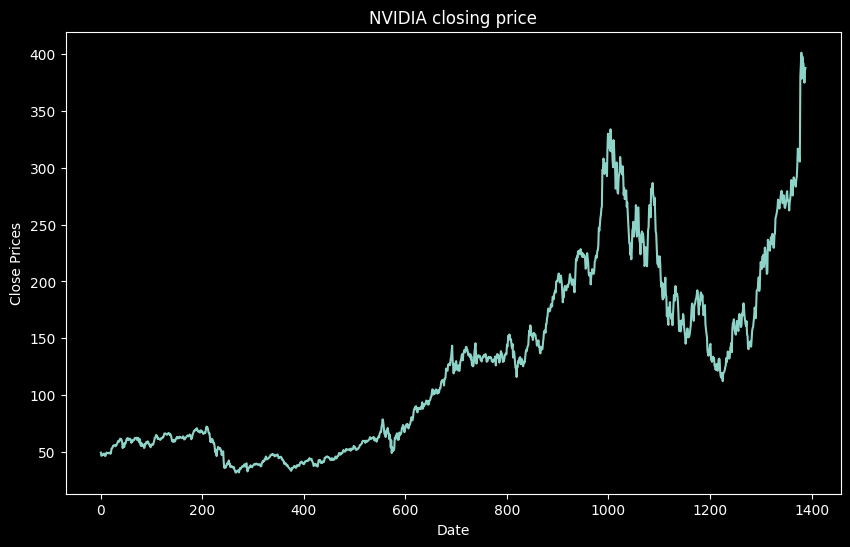

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_nvda['Close'])
plt.title('NVIDIA closing price')
plt.show()

## Train, test, valid

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_nvda = scaler.fit_transform(np.array(data_nvda).reshape(-1,1))

In [ ]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_nvda)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(valid_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Build & train model

In [ ]:
model = SVR()

### Choose k

In [ ]:
param_grid = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', cv=10)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid.best_params_

{'kernel': 'linear'}

### Train

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

## Eval

In [ ]:
y_pred_val = svr.predict(X_val)
y_pred = svr.predict(X_test)

y_pred_val = y_pred_val.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [ ]:
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
eval(org_y_test,y_pred,org_y_val,y_pred_val)

** Testing **
MAE:  42.27728750390554
MAPE:  26.15596925065058
RMSE:  47.11297449918405

** Validate **
MAE:  62.636114412840364
MAPE:  19.1461209362976
RMSE:  70.53671263124859


## Predict

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        print("{} day output {}".format(i,yhat))

        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr.predict(x_input)
        print(yhat)

        temp_input.extend(yhat.tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i=i+1

[0.34569526]
101
1 day output [0.34607385]
2 day output [0.34665922]
3 day output [0.34737591]
4 day output [0.34826788]
5 day output [0.34904854]
6 day output [0.34985556]
7 day output [0.3505066]
8 day output [0.35117556]
9 day output [0.35201906]
10 day output [0.35292678]
11 day output [0.35381217]
12 day output [0.35467754]
13 day output [0.35543746]
14 day output [0.35604281]
15 day output [0.35631779]
16 day output [0.35638901]
17 day output [0.35638662]
18 day output [0.35653523]
19 day output [0.35674929]
20 day output [0.35713688]
21 day output [0.35718526]
22 day output [0.35711234]
23 day output [0.35704842]
24 day output [0.35682735]
25 day output [0.35659266]
26 day output [0.35618271]
27 day output [0.35572176]
28 day output [0.35526041]
29 day output [0.35510797]


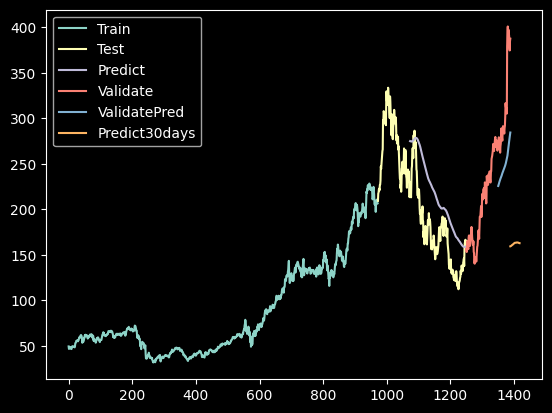

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(valid_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data_nvda)-1, stop=len(data_nvda)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# TESLA

## Data

In [7]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [8]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [10]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [11]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [12]:
data_tsla =df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [13]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

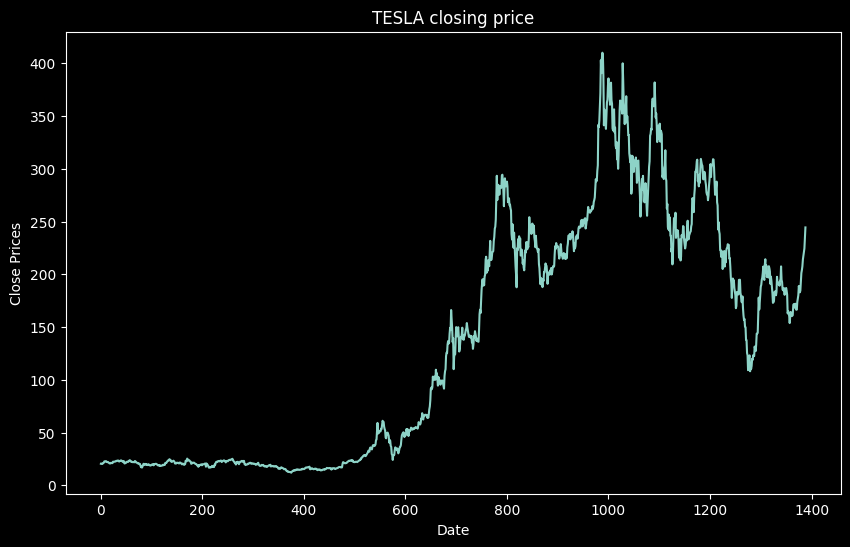

In [14]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
data_tsla = scaler.fit_transform(np.array(data_tsla).reshape(-1,1))

In [16]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_tsla)

In [17]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(valid_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Build & train model

In [18]:
model = SVR()

### Choose k

In [19]:
param_grid = {'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(model, param_grid, scoring = 'neg_root_mean_squared_error', cv=10)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='neg_root_mean_squared_error')

In [20]:
grid.best_params_

{'kernel': 'linear'}

### Train

In [21]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

## Eval

In [22]:
y_pred_val = svr.predict(X_val)
y_pred = svr.predict(X_test)

y_pred_val = y_pred_val.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [23]:
y_pred_val = scaler.inverse_transform(y_pred_val)
y_pred = scaler.inverse_transform(y_pred)

org_y_val = scaler.inverse_transform(y_val.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
eval(org_y_test,y_pred,org_y_val,y_pred_val)

** Testing **
MAE:  20.562781669696296
MAPE:  7.734224770552385
RMSE:  26.625722535069297

** Validate **
MAE:  17.34602685431575
MAPE:  9.53877188760089
RMSE:  20.166936395861917


## Predict

In [25]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        print("{} day output {}".format(i,yhat))

        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = svr.predict(x_input)
        print(yhat)

        temp_input.extend(yhat.tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i=i+1

[0.46026925]
101
1 day output [0.46111026]
2 day output [0.46288575]
3 day output [0.46471093]
4 day output [0.4669851]
5 day output [0.47041589]
6 day output [0.47345743]
7 day output [0.47767767]
8 day output [0.48344576]
9 day output [0.49069526]
10 day output [0.49844629]
11 day output [0.50790722]
12 day output [0.51766136]
13 day output [0.52544058]
14 day output [0.53121281]
15 day output [0.53494494]
16 day output [0.54006876]
17 day output [0.54385695]
18 day output [0.54746331]
19 day output [0.55115822]
20 day output [0.5553954]
21 day output [0.55928115]
22 day output [0.56444103]
23 day output [0.56801946]
24 day output [0.57211643]
25 day output [0.57870647]
26 day output [0.58662409]
27 day output [0.59484672]
28 day output [0.60396839]
29 day output [0.61380794]


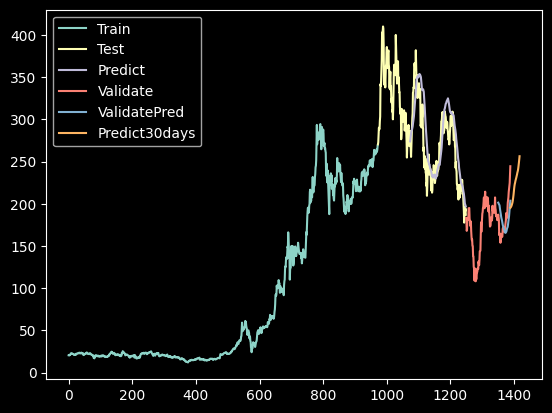

In [26]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(valid_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data_tsla)-1, stop=len(data_tsla)+29, step=1)

plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()